In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
 
#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
from sklearn.metrics import precision_score , recall_score , f1_score  , confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score , classification_report , roc_auc_score, RocCurveDisplay


# EDA

In [146]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



In [147]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



# Clean the data

In [148]:
df=pd.read_csv('cirrhosis.csv')
df=df.drop(columns="ID")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [149]:
df['Status'].replace({'CL':'C'},inplace=True)

In [150]:
#convert target : status of the patient C (censored)or D (death)
df['Status'].replace({'C':0,'D':1},inplace=True)

In [151]:
# convert a column representing days into a column representing years.
df['Age[y]']=df['Age']/365
df=df.drop(columns='Age')

# Deep learning

# part 1 

In [152]:
## Define X and y
y = df['Status']
X=df.drop(columns="Status")

In [153]:
# Perfoming a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [154]:
#  Create the preprocessing pipeline for numeric data
numeric_columns=X_train.select_dtypes("number").columns
# Scaler
scaler=StandardScaler()
#imputer
imputer=SimpleImputer(strategy="median")
# Instantiate the pipeline
numeric_pipe= make_pipeline(imputer,scaler)
# Make the tuple for ColumnTransformer
numeric_tuple= ("numarical",numeric_pipe ,numeric_columns )
print(numeric_tuple)

('numarical', Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())]), Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
      dtype='object'))


In [155]:
# Create the preprocessing pipeline for categorical  data
categorical_columns =X_train.select_dtypes("object").columns
imputer_categorical = SimpleImputer(strategy="constant",fill_value="NA")
#OneHotEncoder
oht_categorical = OneHotEncoder(drop="if_binary", sparse_output=False )
# Instantiate the pipeline
categorical_pipeline= make_pipeline(imputer_categorical,oht_categorical)
# Make the tuple for ColumnTransformer
categorical_tuple= ("categorical" , categorical_pipeline , categorical_columns)

In [156]:
# Create the preprocessing ColumnTransformer
preprocessing_Column= ColumnTransformer([numeric_tuple,categorical_tuple],  remainder="drop", verbose_feature_names_out=False)
preprocessing_Column

ColumnTransformer(transformers=[('numarical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age[y]'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [157]:
X_train_tf = preprocessing_Column.fit_transform(X_train)
X_test_tf = preprocessing_Column.transform(X_test)

In [158]:
X_train_tf

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age[y],Drug_D-penicillamine,Drug_NA,Drug_Placebo,Sex_M,Ascites_N,Ascites_NA,Ascites_Y,Hepatomegaly_N,Hepatomegaly_NA,Hepatomegaly_Y,Spiders_N,Spiders_NA,Spiders_Y,Edema_N,Edema_S,Edema_Y
132,0.827100,-0.358084,-0.126143,1.055965,-1.084819,-0.670351,0.286023,-0.402506,-0.967827,-0.627892,1.114978,1.094673,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
60,2.200277,-0.570223,-0.690815,1.032169,-0.868242,-0.655754,-1.187780,1.194278,-0.494040,2.368624,-2.262326,-0.648012,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
198,-0.305300,-0.216657,0.173378,-0.181392,-0.521720,-0.172817,1.491861,1.301926,0.711025,-0.524564,-0.010790,-0.943761,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
332,-0.374900,-0.051660,-0.234167,0.984579,-0.247391,-0.297505,-0.149419,-0.187210,-0.046003,-0.111251,1.114978,0.476958,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
63,-0.404056,-0.216657,0.080085,-0.014825,-0.521720,-0.407595,0.754960,1.194278,-0.833931,0.302062,-0.010790,1.119106,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2.132559,-0.593794,-0.180155,0.080357,-0.536159,-0.265268,0.152041,-0.743393,-0.349845,-0.731220,-0.010790,-1.708333,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
106,1.383895,-0.570223,-0.710456,1.246327,-1.128134,-0.627167,-0.953311,-0.797217,0.587429,6.605078,-2.262326,1.083219,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
270,-0.326933,-0.475939,-0.175245,-0.014825,0.084693,-0.440439,-0.095394,0.996922,0.309337,-1.041204,-0.010790,-0.036914,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
348,0.882592,-0.381655,-0.234167,0.746626,-0.247391,-0.297505,-0.149419,-0.187210,-0.102652,-0.421236,-1.136558,0.291160,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## ANN

In [159]:
y_train.value_counts(normalize='true')   # 2 calss  

0    0.626198
1    0.373802
Name: Status, dtype: float64

In [160]:
# shape 
input_shape =X_train_tf.shape[1]

In [161]:
def build_model():
    model=Sequential()
    model.add(Dense(64,input_dim=input_shape, activation = 'relu'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss ='bce',optimizer='adam',metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [162]:
calss_model= build_model()
calss_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1856      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


In [163]:
early_stopping= EarlyStopping(monitor='val_accuracy',patience=5)

In [164]:
# fit model 
history=calss_model.fit(X_train_tf,y_train,epochs=50,validation_split=0.2,verbose=0,callbacks=early_stopping)

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'precision_1'}>,
        <Axes: title={'center': 'recall_1'}>], dtype=object))

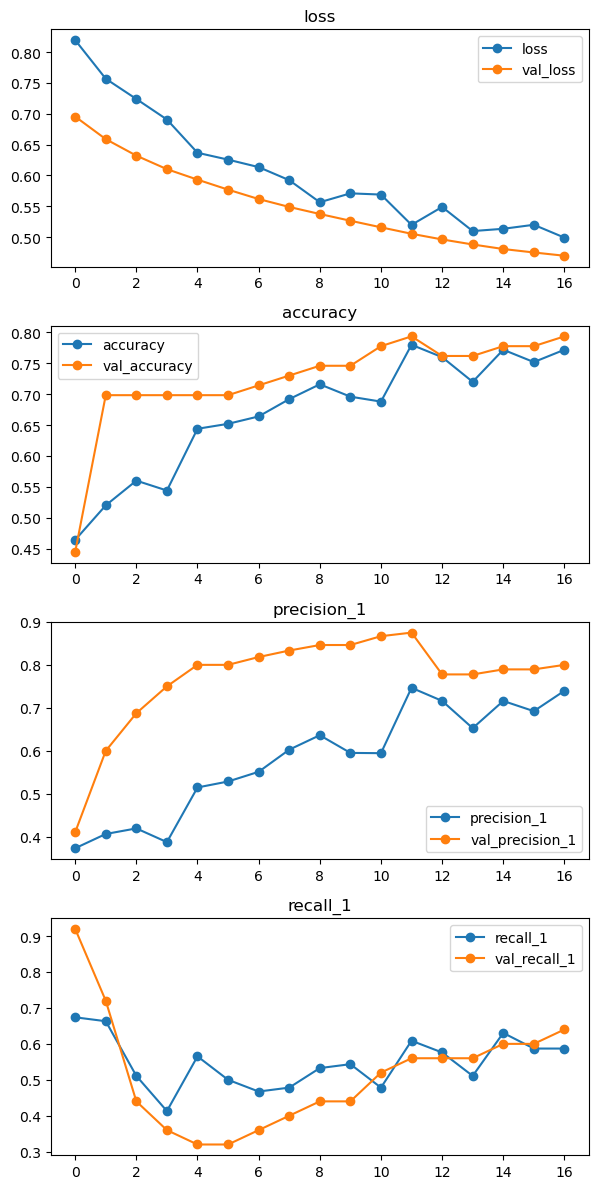

In [165]:
plot_history(history)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        61
           1       0.83      0.77      0.80        44

    accuracy                           0.84       105
   macro avg       0.84      0.83      0.83       105
weighted avg       0.84      0.84      0.84       105



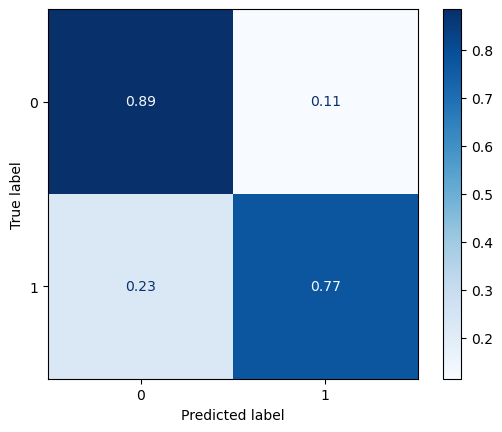

In [166]:
print(classification_report(y_test, y_pred))
 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues',
                                       normalize='true');



4/4 [==============================] - 0s 2ms/step
----------------------------------------------------------------------
 Classification Metrics: 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        61
           1       0.85      0.66      0.74        44

    accuracy                           0.81       105
   macro avg       0.82      0.79      0.80       105
weighted avg       0.82      0.81      0.80       105



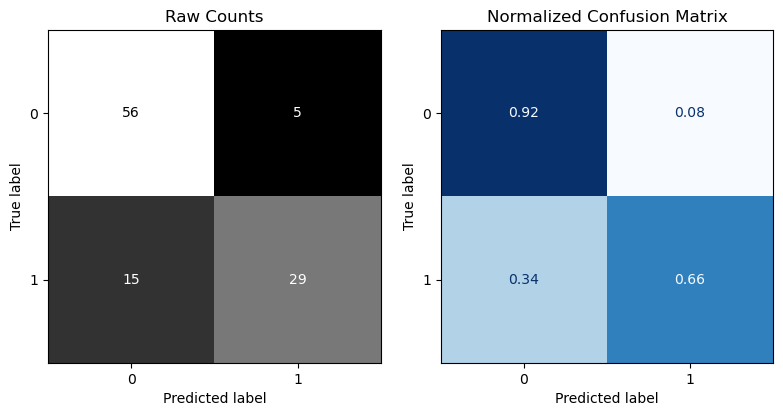

In [167]:
# classification_metrics
y_pred=calss_model.predict(X_test_tf)
y_pred=np.round(y_pred)
classification_metrics(y_test,y_pred)

## Keras tuner

In [168]:
from keras_tuner import HyperParameters as hp 
import keras_tuner as kt 

In [169]:
import os 
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [170]:
def build_model(hp):
    model=Sequential()
    model.add(Dense(units=hp.Int('units',min_value=32 , max_value=128 , step=4 ),input_dim=input_shape, activation = 'relu'))
    model.add(Dense(units=hp.Int('units',min_value=16, max_value=32 , step=4 ),activation='sigmoid'))
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss ='bce',optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [171]:
early_stopping= EarlyStopping(monitor='val_accuracy',patience=5)

In [172]:
tuner =kt.Hyperband(build_model,
                     objective='val_accuracy',max_epochs=50, 
                     seed=42,
                     directory=folder,
                     overwrite = True,
                     project_name='Cirrhosis')

In [173]:
epochs=50
tuner.search(X_train_tf,y_train ,epochs=epochs,validation_split =.2 ,callbacks = [early_stopping])

Trial 90 Complete [00h 00m 04s]
val_accuracy: 0.841269850730896

Best val_accuracy So Far: 0.8571428656578064
Total elapsed time: 00h 03m 50s
INFO:tensorflow:Oracle triggered exit


In [174]:
beat_model = tuner.get_best_models()[0]
beat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 108)               3132      
                                                                 
 dense_1 (Dense)             (None, 108)               11772     
                                                                 
 dropout (Dropout)           (None, 108)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 109       
                                                                 
Total params: 15,013
Trainable params: 15,013
Non-trainable params: 0
_________________________________________________________________


4/4 [==============================] - 0s 2ms/step
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        61
           1       0.80      0.75      0.78        44

    accuracy                           0.82       105
   macro avg       0.82      0.81      0.81       105
weighted avg       0.82      0.82      0.82       105



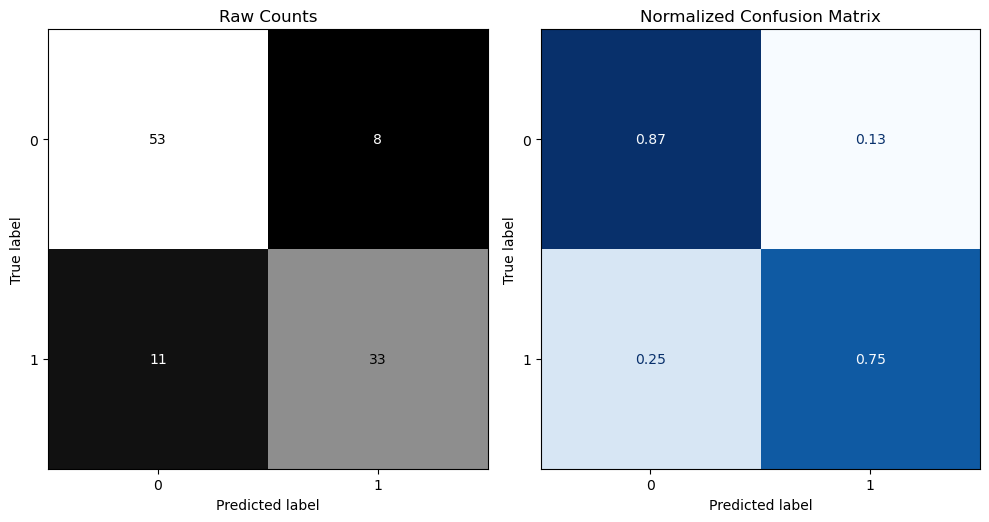

In [175]:
y_pred = beat_model.predict(X_test_tf)
y_pred=np.round(y_pred)
y_pred[:5]
classification_metrics(y_test,y_pred,label='Test Data', figsize=(10,8))